In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spots
from spice.plots import plot_3D
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

float_dtype: <class 'jax.numpy.float32'>


In [3]:
t = TransformerPayne.download()

In [5]:
m = IcosphereModel.construct(10000, 1.9, 1.5,
                             t.to_parameters(dict(logteff=np.log10(8000), logg=4.0,
                                                  Fe=-4.0), relative=False),
                             t.stellar_parameter_names, override_log_g=False)

In [7]:
incl = 60.
# Calculate v_e from v_e*sin(incl) = 40 km/s
v_e_sin_i = 40.  # km/s
incl_rad = np.deg2rad(incl)
v_e = v_e_sin_i / np.sin(incl_rad)
print(f"v_e = {v_e:.2f} km/s (with v_e*sin(i) = {v_e_sin_i} km/s at inclination {incl}°)")

v_e = 46.19 km/s (with v_e*sin(i) = 40.0 km/s at inclination 60.0°)


In [8]:
from spice.models.mesh_view import get_mesh_view
from spice.models.utils import inclination_to_los_axis, lat_to_theta, lon_to_phi, velocity_to_period

period_seconds = velocity_to_period(v_e, m.radius)
timestamps = jnp.linspace(0, period_seconds, 10)

# Convert inclination to LOS vector
mt = get_mesh_view(add_rotation(m, v_e), los_vector=inclination_to_los_axis(incl))

SPOT_RADIUS = 25.

ms = add_spots(mt,
               spot_center_thetas=jnp.array([lat_to_theta(lat_deg) for lat_deg in [-30, 0, 30, 60]]),
               spot_center_phis=jnp.array([lon_to_phi(lon_deg) for lon_deg in [-90, 0, 90, 180]]),
               spot_radii=jnp.array(4*[SPOT_RADIUS]),
               parameter_deltas=jnp.array(4*[1.5]),
               parameter_indices=jnp.array(4*[27]),
               smoothness=jnp.array(4*[0.5]))


In [9]:
mts = [evaluate_rotation(ms, t) for t in tqdm(timestamps)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.28it/s]


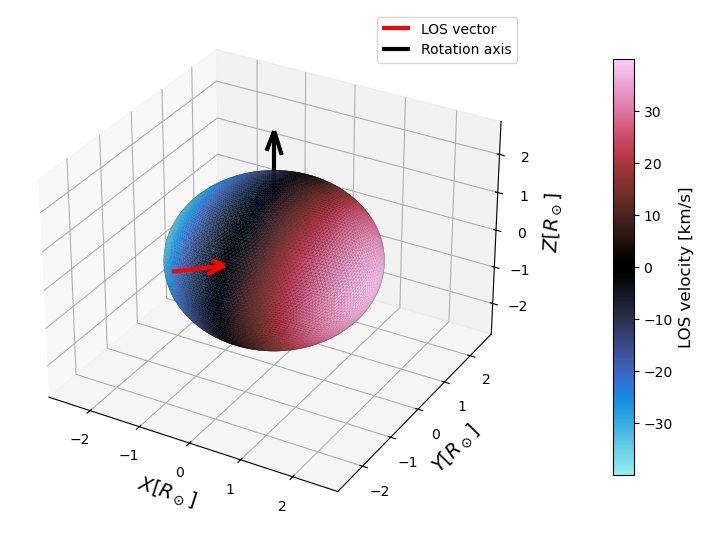

In [11]:
fig, _ = plot_3D(mts[0], 'los_velocities');

/home/100/mj8805/.local/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


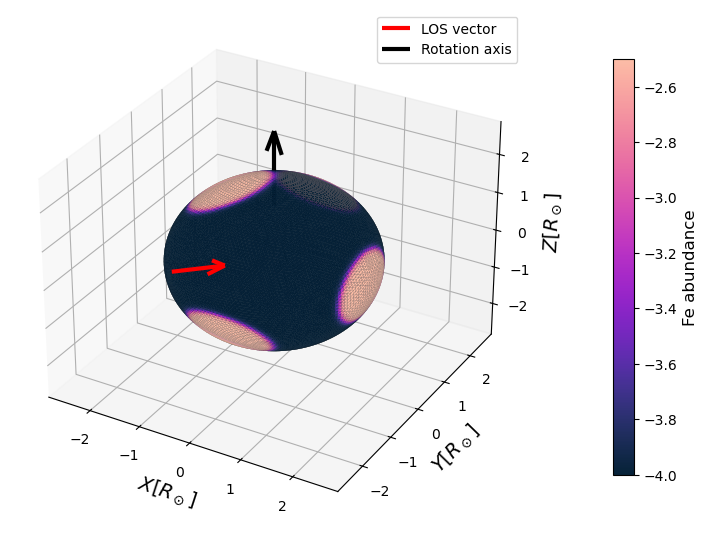

In [12]:
fig, _ = plot_3D(mts[0], 27, property_label='Fe abundance');

In [13]:
fig.savefig('kochukov.png', dpi=300, bbox_inches='tight')

In [14]:
from tqdm import tqdm

In [26]:
# Calculate wavelength resolution
wavelength_range = 5002 - 5000  # Å
num_points = 200
resolution = wavelength_range / (num_points - 1)
print(f"Wavelength resolution: {num_points/resolution:.4f} Å")

vws = jnp.linspace(5000, 5002, 200)
spec = []
for mt in tqdm(mts):
    spec.append(simulate_observed_flux(t.intensity, mt, jnp.log10(vws), chunk_size=2048))

Wavelength resolution: 19900.0000 Å


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:25<00:00, 14.55s/it]


In [27]:
spec = np.array(spec)
np.save('fe_specs.npy', spec)

In [28]:
import matplotlib.pyplot as plt

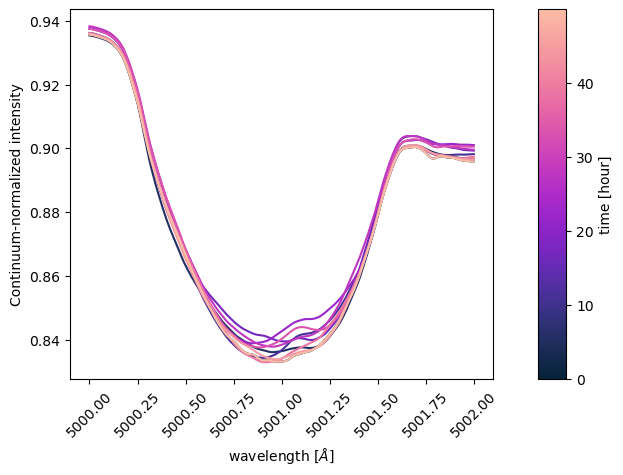

In [41]:
import matplotlib as mpl
import cmasher as cmr

fig, ax = plt.subplots(nrows=1, ncols=2, width_ratios=(15, 1))

n_lines = len(spec)
cmap = cmr.bubblegum

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

from scipy.ndimage import gaussian_filter1d

for s, c in zip(spec, colors):
    # Apply Gaussian smoothing to the spectrum
    smoothed_spectrum = gaussian_filter1d(s[:, 0]/s[:, 1], sigma=2)
    ax[0].plot(vws, smoothed_spectrum, color=c)
    
ax[0].set_xlabel(r'wavelength [$\AA$]')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('Continuum-normalized intensity');

norm = mpl.colors.Normalize(vmin=timestamps[0]/3600, vmax=timestamps[-1]/3600)
cbar = ax[1].figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='cmr.bubblegum'),
            cax=ax[1], pad=.1);
cbar.set_label('time [hour]');

In [42]:
fig.savefig('kochukov_iron.png', dpi=300, bbox_inches='tight')

In [40]:
LINE_NAMES = [
    'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Cr II', 'Fe II', 'Fe II'
]

LINE_CENTERS = [
    5005.7122, 5006.1186, 5242.4907, 5263.3062, 5367.4659, 5383.3685, 5397.1279, 6146.1788, 6147.7341, 6149.2459
]
# Calculate spectra for all the iron lines defined in LINE_CENTERS
all_line_specs = []

# Define wavelength ranges around each line center
for line_center in tqdm(LINE_CENTERS, desc="Line", leave=False):
    # Create wavelength range around the line center (±1 Angstrom with 1000 points)
    line_vws = jnp.linspace(line_center - 2, line_center + 2, 100)
    
    line_specs = []
    for mt in tqdm(mts):
        line_specs.append(simulate_observed_flux(t.intensity, mt, jnp.log10(line_vws), chunk_size=2048))
    
    all_line_specs.append(np.array(line_specs))

# Save the calculated spectra to a file
np.save('all_fe_lines_specs.npy', all_line_specs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.25s/it]


/jobfs/143886695.gadi-pbs/ipykernel_787779/1659899720.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('cmr.bubblegum')
/jobfs/143886695.gadi-pbs/ipykernel_787779/1659899720.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


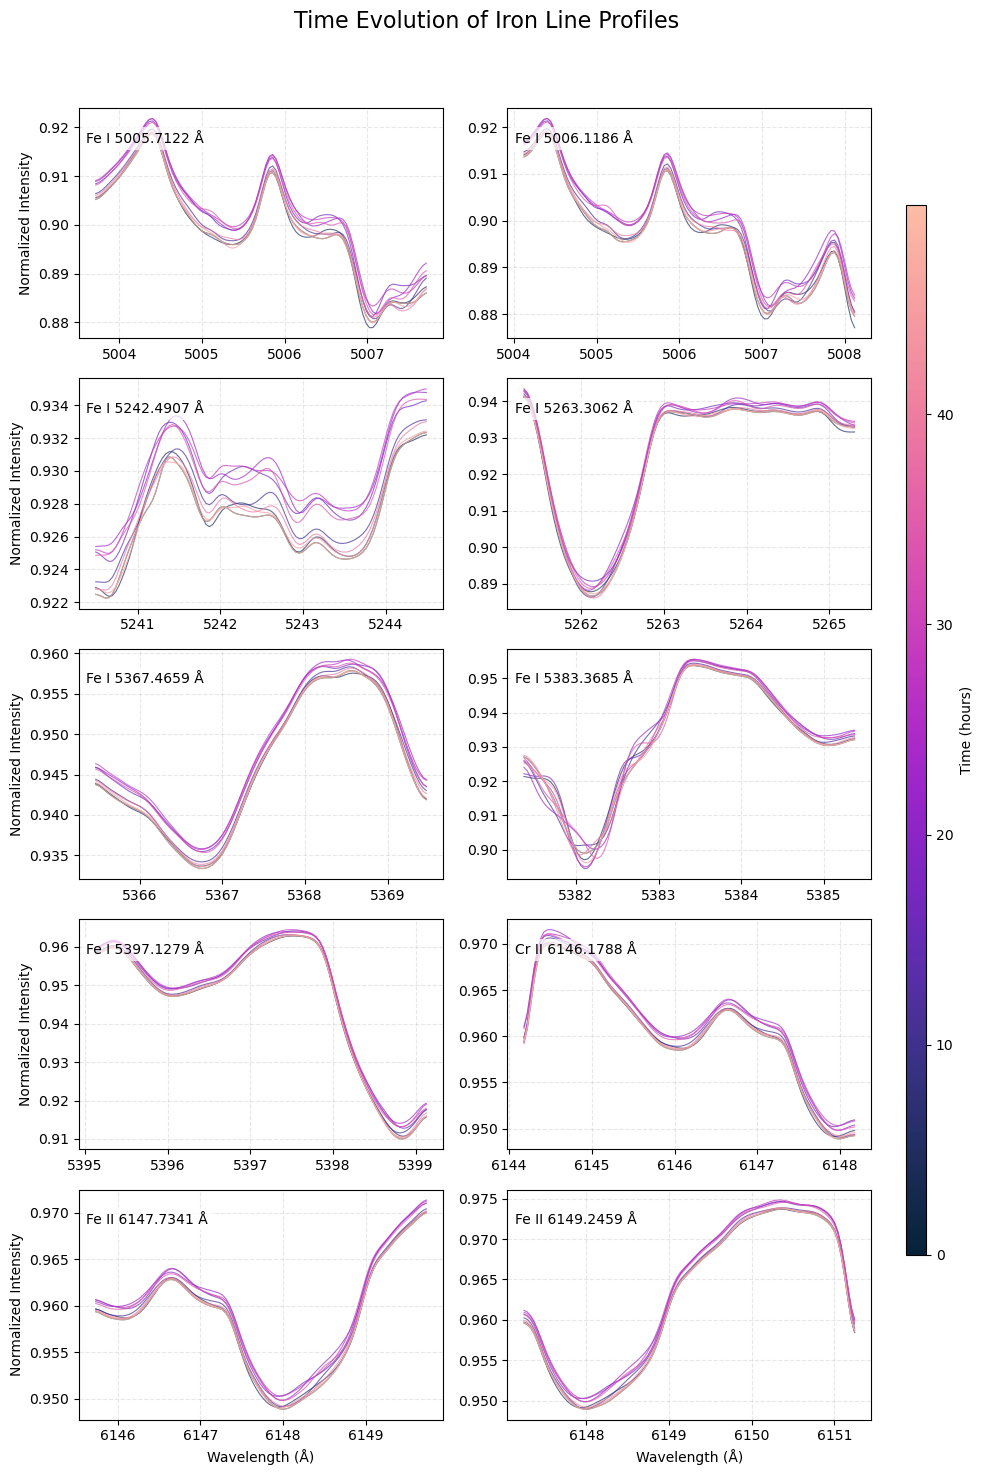

In [43]:
# Load the calculated spectra if they exist, otherwise use the ones we just calculated
try:
    all_line_specs = np.load('all_fe_lines_specs.npy')
except FileNotFoundError:
    pass  # Use the ones we just calculated

# Create a 2D grid of subplots to display all the iron lines
n_rows = 5
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15))
axs = axs.flatten()  # Flatten the 2D array for easier indexing

# Create a colormap for the time evolution
cmap = plt.cm.get_cmap('cmr.bubblegum')
norm = mpl.colors.Normalize(vmin=timestamps[0]/3600, vmax=timestamps[-1]/3600)

# Plot each line in its own subplot
for i, (line_center, line_name, line_specs) in enumerate(zip(LINE_CENTERS, LINE_NAMES, all_line_specs)):
    if i >= len(axs):
        break  # In case we have more lines than subplots
        
    # Create wavelength range around the line center
    line_vws = np.linspace(line_center - 2, line_center + 2, 100)
    
    # Plot each spectrum with color representing time
    for j, (spec, time) in enumerate(zip(line_specs, timestamps)):
        color = cmap(norm(time/3600))
        # Apply Gaussian smoothing to simulate spectroscope resolution
        smoothed_spectrum = gaussian_filter1d(spec[:, 0]/spec[:, 1], sigma=2)
        axs[i].plot(line_vws, smoothed_spectrum, color=color, alpha=0.7, linewidth=0.8)
    
    # Add line information
    axs[i].text(0.02, 0.85, f'{line_name} {line_center:.4f} Å', 
                transform=axs[i].transAxes, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3))
    
    # # Set y-axis limits to focus on the line profile
    # y_min = np.min([np.min(spec[:, 0]/spec[:, 1]) for spec in line_specs]) - 0.05
    # y_max = 1.05
    # axs[i].set_ylim(y_min, y_max)
    
    # Add grid for better readability
    axs[i].grid(True, linestyle='--', alpha=0.3)

# Hide any unused subplots
for i in range(len(LINE_CENTERS), len(axs)):
    axs[i].set_visible(False)

# Add labels to the figure
for i in range(n_rows):
    # Add y-axis label to the leftmost subplot of each row
    axs[i*n_cols].set_ylabel('Normalized Intensity')
    
for i in range(n_cols * (n_rows-1), n_cols * n_rows):
    # Add x-axis label to the bottom row
    if i < len(LINE_CENTERS):
        axs[i].set_xlabel('Wavelength (Å)')

# Add a colorbar to show the time evolution
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label('Time (hours)')

# Add a title to the figure
fig.suptitle('Time Evolution of Iron Line Profiles', fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()
